## Estimating real COVID-19 death toll in Italy. 

In [1]:
import pandas as pd
import xlrd, os
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
params = {'axes.grid': True,
          'axes.titlesize': 10,
          'axes.labelsize' : 10,
          'figure.figsize' : [12, 5],
          'xtick.labelsize' : 10, 
          'ytick.labelsize' : 10}
plt.rcParams.update(params)

### Preparing the data

In [2]:
file_name = '/Users/andrea/venvs/covid_ita/tables/comuni_giornaliero.csv'
df = pd.read_csv(file_name, encoding = "ISO-8859-1")
df.rename({"REG": "reg_code","NOME_REGIONE": "reg_name", "NOME_PROVINCIA": "prov_name", "NOME_COMUNE": "municip_name", "COD_PROVCOM": "municip_code",
           "GE": "mmdd",'T_20':'deaths_2020','T_19':'deaths_2019','T_18':'deaths_2018','T_17':'deaths_2017',
           'T_16':'deaths_2016','T_15':'deaths_2015'},axis='columns',inplace =True)

In [3]:
df_sampled = df[df['deaths_2020']!='n.d.'].copy()
df_sampled['deaths_2020'] = df_sampled['deaths_2020'].astype(int)

In [4]:
df_sampled = df_sampled[df_sampled['mmdd']>131]#.copy() #keep only from 1st feb
df_sampled = df_sampled[df_sampled['mmdd']<401]#.copy() #keep only until 1st apr

In [5]:
df_sampled['baseline_deaths'] = df_sampled[['deaths_2019', 'deaths_2018','deaths_2017','deaths_2016','deaths_2015']].mean(axis=1)
df_sampled['excess_deaths'] = df_sampled['deaths_2020'] - df_sampled['baseline_deaths']

In [6]:
df_sampled = df_sampled[df_sampled['mmdd']!=229].copy() #removing 29 feb
df_sampled["mmdd_format"] = df_sampled.mmdd.map("{:04}".format)
df_sampled['date'] = pd.to_datetime('2020' + df_sampled.mmdd_format,format='%Y%m%d') 

### National overview

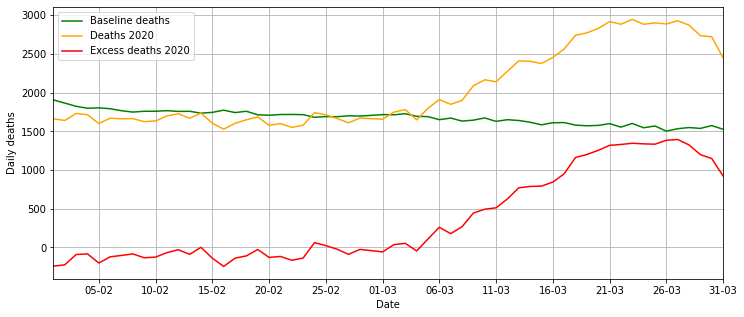

In [7]:
df_country = df_sampled.groupby(by=['date'], as_index=False)[['excess_deaths','baseline_deaths','deaths_2020']].sum()
#create chart
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df_country['date'], df_country['baseline_deaths'],color='green', label = 'Baseline deaths')
ax.plot(df_country['date'], df_country['deaths_2020'],color='orange', label = 'Deaths 2020')
ax.plot(df_country['date'], df_country['excess_deaths'],color='red', label = 'Excess deaths 2020')
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
ax.set_xlim([df_country['date'].iloc[0], df_country['date'].iloc[-1]])
plt.ylabel('Daily deaths')
plt.xlabel('Date')
plt.legend(loc='best')
plt.show()

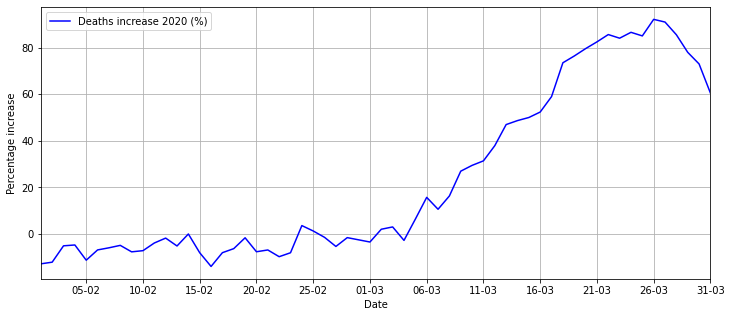

In [8]:
df_country['perc_excess'] = df_country['excess_deaths'] / df_country['baseline_deaths'] * 100
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df_country['date'], df_country['perc_excess'],color='blue', label = 'Deaths increase 2020 (%)')
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
ax.set_xlim([df_country['date'].iloc[0], df_country['date'].iloc[-1]])
plt.legend(loc='best')
plt.ylabel('Percentage increase')
plt.xlabel('Date')
plt.show()

### March 2020 death toll

In [9]:
df_sampled_march = df_sampled[(df_sampled['mmdd'] >= 301) & (df_sampled['mmdd'] <= 331 )]
df_country_march_excess = df_sampled_march['excess_deaths'].sum()
df_country_march_baseline = df_sampled_march['baseline_deaths'].sum()
df_country_march_perc_excess = df_country_march_excess / df_country_march_baseline * 100
print("Deaths in Italy have increased by %s percent in March 2020" % (round(df_country_march_perc_excess,2)))

Deaths in Italy have increased by 49.36 percent in March 2020


### Excess deaths VS official COVID-19 deaths

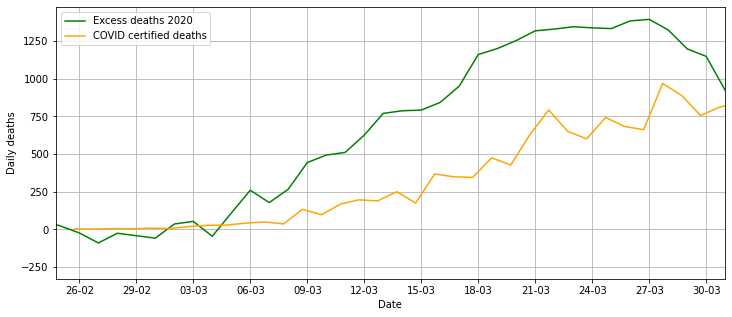

Excess deaths in March 2020: 24668.4 
Officially certified COVID-19 deaths March 2020: 12399
Excess deaths explained by official figures: 50.26 percent


In [10]:
civ_prot_data = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv")
civ_prot_data['diff_deceduti'] = civ_prot_data['deceduti'].diff()
dates = civ_prot_data['data']
date_format = [pd.to_datetime(d) for d in dates]
#creating chart
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df_country['date'], df_country['excess_deaths'],color='green', label = 'Excess deaths 2020')
ax.plot(date_format, civ_prot_data['diff_deceduti'],color='orange', label = 'COVID certified deaths')
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 3))
ax.set_xlim([date_format[0], df_country['date'].iloc[-1]])
plt.legend(loc='best')
plt.ylabel('Daily deaths')
plt.xlabel('Date')
plt.show()
#comparing ISTAT excess death and Civil Protection for march 2020
official_deaths_march = int(civ_prot_data[civ_prot_data['data'].str.contains('2020-03')]['diff_deceduti'].sum())
print ("Excess deaths in March 2020: %s \nOfficially certified COVID-19 deaths March 2020: %s" % (df_country_march_excess, official_deaths_march))
print ("Excess deaths explained by official figures: %s percent" % (round((official_deaths_march/df_country_march_excess*100),2)))


### Regional breakdown

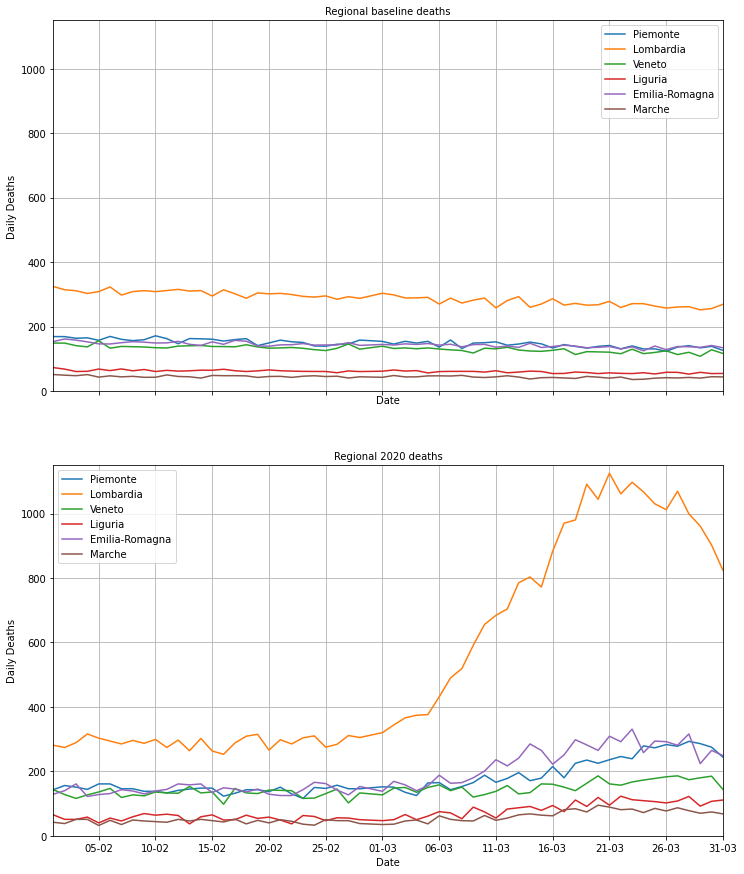

In [11]:
df_regions_dataseries = df_sampled.groupby(by=['reg_code','date',"reg_name"], as_index=False)[['excess_deaths','baseline_deaths','deaths_2020']].sum()
df_regions_dataseries['perc_excess'] = df_regions_dataseries['excess_deaths'] / df_regions_dataseries['baseline_deaths'] * 100
df_regions_sum = df_sampled.groupby(by=['reg_code',"reg_name"], as_index=False)['excess_deaths'].sum()
most_affected_regions = df_regions_sum.nlargest(6, columns=['excess_deaths'])
df_regions_dataseries_filtered = df_regions_dataseries[df_regions_dataseries['reg_code'].isin(most_affected_regions.reg_code)]
#create charts
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 15))
for key, grp in df_regions_dataseries_filtered.groupby(['reg_code']):
    ax1.plot(grp['date'], grp['baseline_deaths'], label=grp['reg_name'].iloc[0])
    ax2.plot(grp['date'], grp['deaths_2020'], label=grp['reg_name'].iloc[0])
date_form = DateFormatter("%d-%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=5))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(), loc='best', ncol=1)
ax2.legend(by_label.values(), by_label.keys(), loc='best', ncol=1)
ax1.set(title='Regional baseline deaths')
ax2.set(title='Regional 2020 deaths')
ax1.set_xlim([grp['date'].iloc[0], grp['date'].iloc[-1]])
ax1.set_ylim([0, 1150])
ax2.set_ylim([0, 1150])
plt.setp((ax1, ax2), ylabel='Daily Deaths')
plt.setp((ax1, ax2), xlabel='Date')
plt.show()

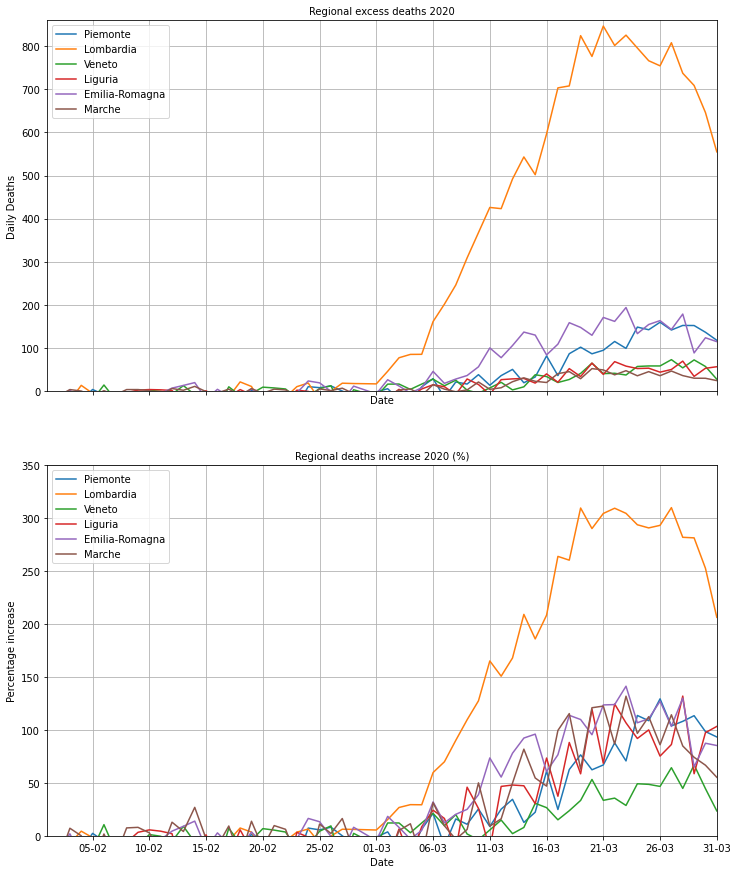

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 15))
for key, grp in df_regions_dataseries_filtered.groupby(['reg_code']):
    ax1.plot(grp['date'], grp['excess_deaths'], label=grp['reg_name'].iloc[0])
    ax2.plot(grp['date'], grp['perc_excess'], label=grp['reg_name'].iloc[0])
date_form = DateFormatter("%d-%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=5))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(), loc='best', ncol=1)
ax2.legend(by_label.values(), by_label.keys(), loc='best', ncol=1)
ax1.set(title='Regional excess deaths 2020')
ax2.set(title='Regional deaths increase 2020 (%)')
ax1.set_xlim([grp['date'].iloc[0], grp['date'].iloc[-1]])
ax1.set_ylim([0, 860])
ax2.set_ylim([0, 350])
plt.setp((ax1), ylabel='Daily Deaths')
plt.setp((ax2), ylabel='Percentage increase')
plt.setp((ax1, ax2), xlabel='Date')
plt.show()

### Mapping regional deaths increase

    reg_code                      reg_name  excess_deaths  baseline_deaths  \
2          3                     Lombardia        15837.8           8492.2   
7          8                Emilia-Romagna         3020.6           4309.4   
3          4  Trentino-Alto Adige/Südtirol          520.0            798.0   
1          2  Valle d'Aosta/Vallée d'Aoste           73.6            122.4   
10        11                        Marche          706.4           1325.6   
6          7                       Liguria          906.2           1801.8   
0          1                      Piemonte         2060.6           4382.4   
4          5                        Veneto          940.6           3873.4   
8          9                       Toscana          483.6           3508.4   
19        20                      Sardegna          156.0           1139.0   
5          6         Friuli-Venezia Giulia           92.0            942.0   
12        13                       Abruzzo          103.2       

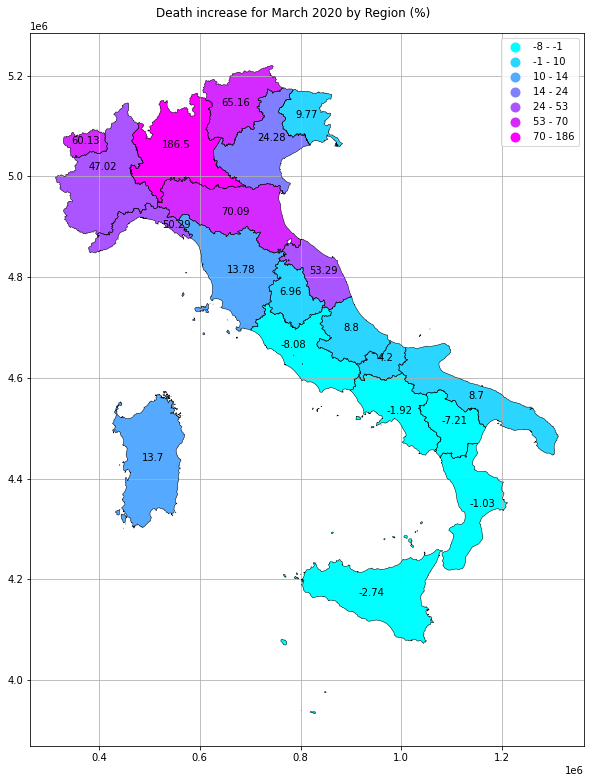

In [13]:
df_regions_march = df_sampled_march.groupby(by=['reg_code',"reg_name"], as_index=False)[['excess_deaths','baseline_deaths','deaths_2020']].sum()
df_regions_march['perc_excess'] = df_regions_march['excess_deaths'] / df_regions_march['baseline_deaths'] * 100
df_regions_march = df_regions_march.sort_values(by=['perc_excess'], ascending=False)
print(df_regions_march)

import geopandas as gpd
import os
#opening shapefile
df = gpd.read_file(os.path.join("/Users/andrea/Downloads/Limiti01012018_g 3/Reg01012018_g",'Reg01012018_g_WGS84.shp'))
#joining model outputs to the shapefile
#map settings
df = df.merge(df_regions_march, left_on='COD_REG', right_on= 'reg_code')
fig, ax = plt.subplots(figsize = (15,12))
fig.subplots_adjust(top=0.95)
fig.suptitle('Death increase for March 2020 by Region (%)',fontsize = 12)
pl = df.plot(column = 'perc_excess',cmap = 'cool',ax=ax, legend=True, scheme='natural_breaks', k = 7)
df.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.5,ax=ax) 
#adding labels
df['coords'] = df['geometry'].apply(lambda x: x.representative_point().coords[:])
df['coords'] = [coords[0] for coords in df['coords']]
for idx, row in df.iterrows():
    plt.annotate(s=str(round(row['perc_excess'],2)), xy=row['coords'],
                 horizontalalignment='center')
#formatting legend labels
leg = pl.get_legend()
for lbl in leg.get_texts():
    label_text = lbl.get_text()
    lower = label_text.split()[0]
    upper = label_text.split()[2]
    new_text = f'{float(lower):,.0f} - {float(upper):,.0f}'
    lbl.set_text(new_text)
    
plt.savefig("Regional death increase for March 2020.png")


### Provincial level analysis

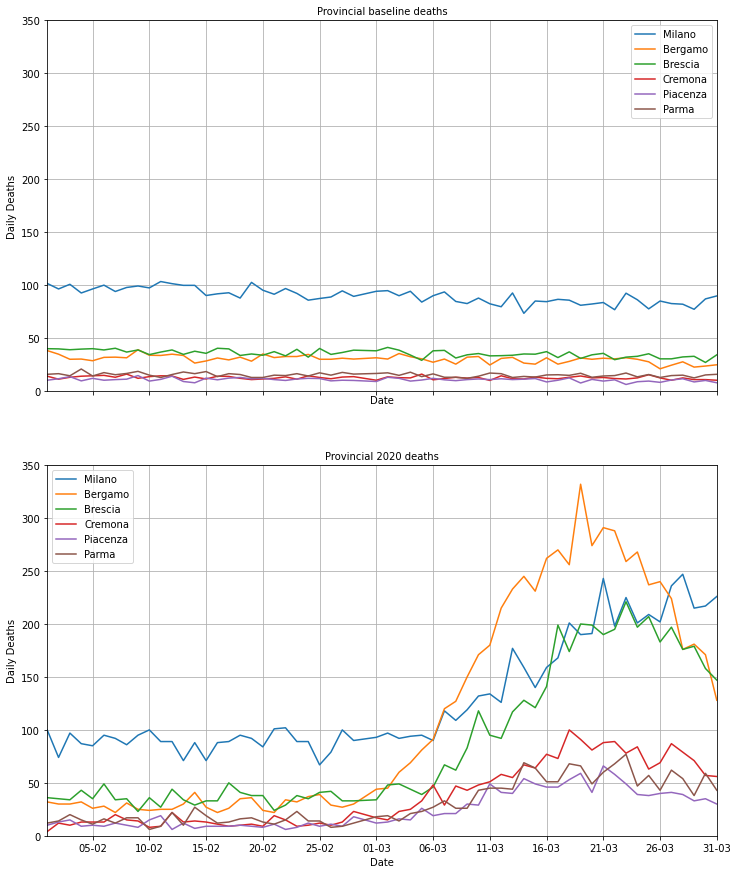

In [23]:
df_provinces_dataseries = df_sampled.groupby(by=['PROV',"prov_name",'date'], as_index=False)[['excess_deaths','baseline_deaths','deaths_2020']].sum()
df_provinces_sum = df_sampled.groupby(by=['PROV',"prov_name"], as_index=False)['excess_deaths'].sum()
most_affected_provinces = df_provinces_sum.nlargest(6, columns=['excess_deaths'])
df_provinces_dataseries = df_provinces_dataseries[df_provinces_dataseries['PROV'].isin(most_affected_provinces.PROV)]
#creating chart
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1,sharex=True,figsize=(12, 15))
for key, grp in df_provinces_dataseries.groupby(['PROV']):
    ax1.plot(grp['date'], grp['baseline_deaths'], label = grp['prov_name'].iloc[0])
    ax2.plot(grp['date'], grp['deaths_2020'], label=grp['prov_name'].iloc[0])
date_form = DateFormatter("%d-%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(),loc='best',ncol=1)
ax2.legend(by_label.values(), by_label.keys(),loc='best',ncol=1)
ax1.set(title='Provincial baseline deaths')
ax2.set(title='Provincial 2020 deaths')
ax1.set_xlim([grp['date'].iloc[0], grp['date'].iloc[-1]])
ax1.set_ylim([0, 350])
ax2.set_ylim([0, 350])
plt.setp((ax1, ax2), ylabel='Daily Deaths')
plt.setp((ax1, ax2), xlabel='Date')
plt.show()

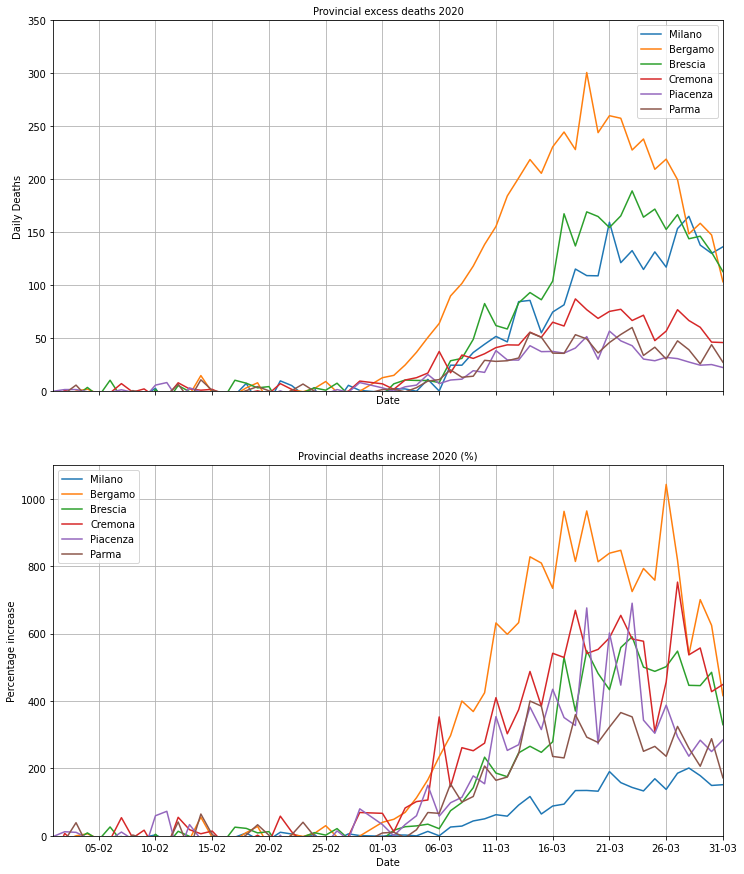

In [20]:
df_provinces_dataseries['perc_excess'] = df_provinces_dataseries['excess_deaths'] / df_provinces_dataseries['baseline_deaths'] * 100
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1,sharex=True,figsize=(12, 15))
for key, grp in df_provinces_dataseries.groupby(['PROV']):
    ax1.plot(grp['date'], grp['excess_deaths'], label = grp['prov_name'].iloc[0])
    ax2.plot(grp['date'], grp['perc_excess'], label=grp['prov_name'].iloc[0])
date_form = DateFormatter("%d-%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys(),loc='best',ncol=1)
ax2.legend(by_label.values(), by_label.keys(),loc='best',ncol=1)
ax1.set(title='Provincial excess deaths 2020')
ax2.set(title='Provincial deaths increase 2020 (%)')
ax1.set_xlim([grp['date'].iloc[0], grp['date'].iloc[-1]])
ax1.set_ylim([0, 350])
ax2.set_ylim([0, 1100])
plt.setp((ax1), ylabel='Daily Deaths')
plt.setp((ax2), ylabel='Percentage increase')
plt.setp((ax1, ax2), xlabel='Date')
plt.show()

### Mapping provincial excess of deaths

     PROV                     prov_name  excess_deaths  baseline_deaths  deaths_2020  perc_excess
15     16                       Bergamo         5032.4            886.6         5919   567.606587
18     19                       Cremona         1486.6            379.4         1866   391.829204
97     98                          Lodi          745.0            201.0          946   370.646766
16     17                       Brescia         3054.8           1051.2         4106   290.601218
32     33                      Piacenza          832.6            315.4         1148   263.982245
33     34                         Parma          952.8            457.2         1410   208.398950
96     97                         Lecco          485.0            278.0          763   174.460432
17     18                         Pavia          796.6            599.4         1396   132.899566
19     20                       Mantova          492.6            403.4          896   122.112048
40     41           

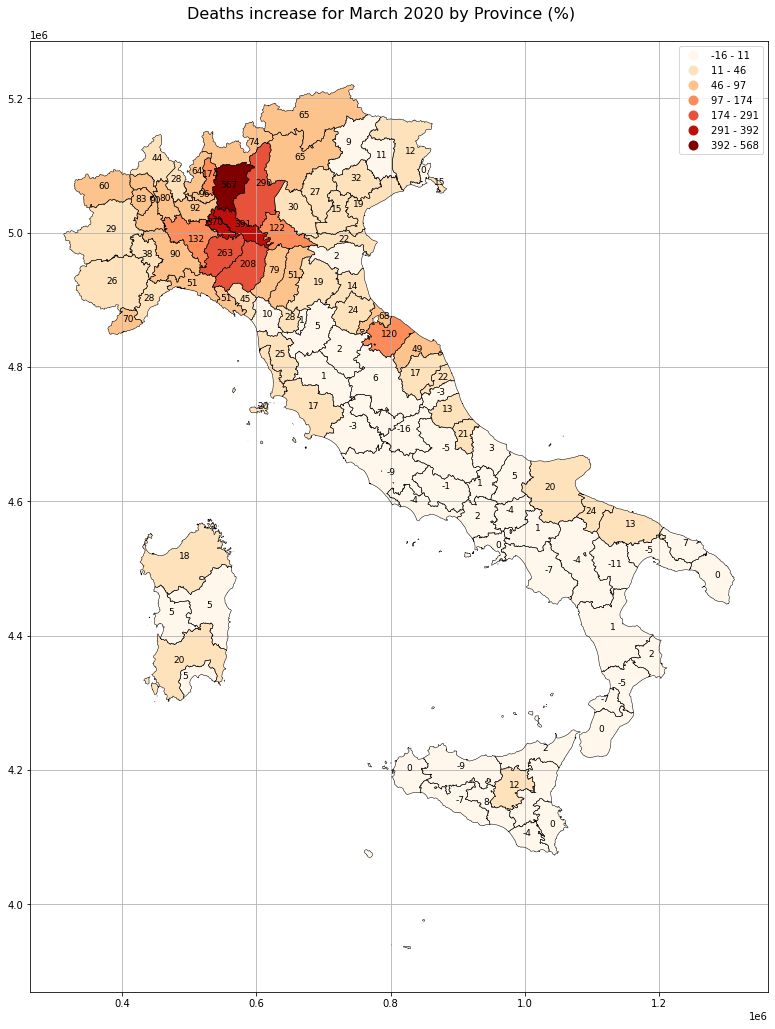

In [24]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df_prov_march = df_sampled_march.groupby(by=['PROV',"prov_name"], as_index=False)[['excess_deaths','baseline_deaths','deaths_2020']].sum()
df_prov_march['perc_excess'] = df_prov_march['excess_deaths'] / df_prov_march['baseline_deaths'] * 100
df_prov_march = df_prov_march.sort_values(by=['perc_excess'], ascending=False)
print(df_prov_march)
df_prov_march.head(50).to_csv('provincial_analysis_outputs.csv')
#opening shapefile
df = gpd.read_file(os.path.join("/Users/andrea/Downloads/Limiti01012018_g 3/ProvCM01012018_g",'ProvCM01012018_g_WGS84.shp'))
#joining model outputs to the shapefile
df = df.merge(df_prov_march, left_on='COD_PROV', right_on= 'PROV')
fig, ax = plt.subplots(figsize = (20,16))
fig.subplots_adjust(top=0.95)
fig.suptitle('Deaths increase for March 2020 by Province (%)',fontsize = 16)
pl = df.plot(column = 'perc_excess',ax=ax, legend=True,cmap='OrRd', scheme='natural_breaks', k = 7)
df.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.5,ax=ax) 
#adding labels
df['coords'] = df['geometry'].apply(lambda x: x.representative_point().coords[:])
df['coords'] = [coords[0] for coords in df['coords']]
for idx, row in df.iterrows():
    plt.annotate(s=str(int(row['perc_excess'])), xy=row['coords'],
                 horizontalalignment='center', size = 9)
#formatting legend labels
leg = pl.get_legend()
for lbl in leg.get_texts():
    label_text = lbl.get_text()
    lower = label_text.split()[0]
    upper = label_text.split()[2]
    new_text = f'{float(lower):,.0f} - {float(upper):,.0f}'
    lbl.set_text(new_text)
plt.savefig("Provincial deaths increase for March 2020 (%).png", dpi=300)